In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%run ./scripts/util_func.py

In [2]:
# import data to dataframe

data = pd.read_csv("/home/dominic/Documents/publications/sensors2021/offline_model_training/powertrain_dynamics_IPEM/data/data_joint_states.csv") 

data = data.iloc[1:]

print(data)

       Unnamed: 0      ros_time  wheel_meas_index  cmd_left_vel  \
1               1  1.604067e+18               0.0           0.0   
2               2  1.604067e+18               0.0           0.0   
3               3  1.604067e+18               0.0           0.0   
4               4  1.604067e+18               0.0           0.0   
5               5  1.604067e+18               0.0           0.0   
...           ...           ...               ...           ...   
88271       88271  1.604068e+18            3366.0           0.0   
88272       88272  1.604068e+18            3366.0           0.0   
88273       88273  1.604068e+18            3366.0           0.0   
88274       88274  1.604068e+18            3366.0           0.0   
88275       88275  1.604068e+18            3366.0           0.0   

       meas_left_vel  cmd_right_vel  meas_right_vel  left_js_vel  \
1                0.0            0.0         0.00000          0.0   
2                0.0            0.0         0.00000        

In [3]:
# convert dataframe to numpy array

array = data.to_numpy()
array =np.delete(array,[0],axis=0)

time_arr = array[:,1]
time_arr = (time_arr - time_arr[0]) * 10**(-9)
meas_index_arr = array[:,2]

left_vel_cmd_arr = array[:,3]
left_vel_meas_arr = array[:,4]
right_vel_cmd_arr = array[:,5]
right_vel_meas_arr = array[:,6]


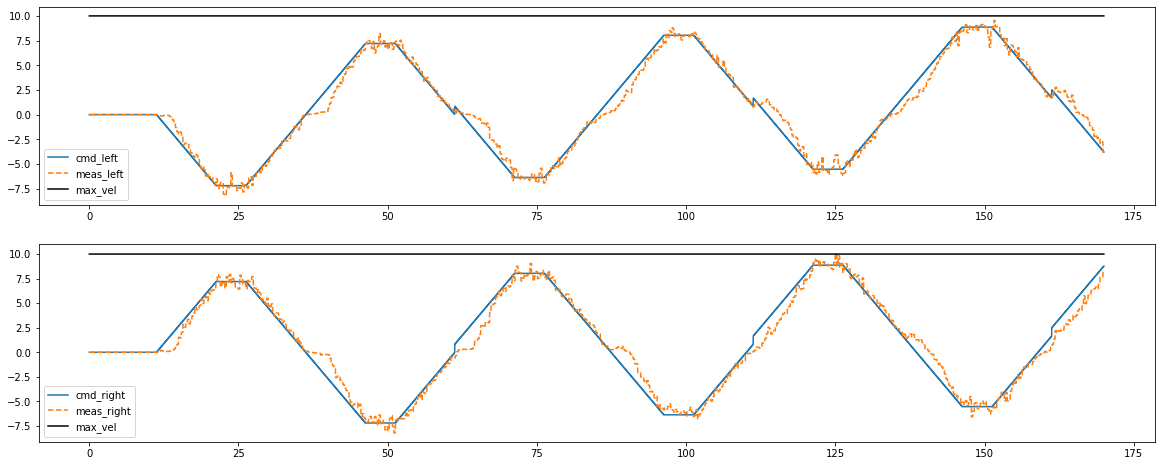

In [4]:
# plot commanded and measured wheel velocities
slice_start = 1
slice_end = 17000

max_vel = np.full(time_arr.shape[0], 10)

plt.figure(1, figsize=(20,8))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], max_vel[slice_start:slice_end], c='black', label='max_vel')
plt.legend()
plt.subplot(212)
plt.plot(time_arr[slice_start:slice_end], right_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_right')
plt.plot(time_arr[slice_start:slice_end], right_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_right')
plt.plot(time_arr[slice_start:slice_end], max_vel[slice_start:slice_end], c='black', label='max_vel')
plt.legend()

plt.show()

In [5]:
# Run model on all data

# init tau_c and tau_d values

tau_c = 0.2
tau_d = 0.25

left_model_vel = np.zeros((meas_index_arr.shape[0]))
right_model_vel = np.zeros((meas_index_arr.shape[0]))

for i in range(10, meas_index_arr.shape[0]-1):
    
    dt = (time_arr[i] - time_arr[i-1])
    left_model_vel[i+1] = powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_model_vel, i, dt)
    right_model_vel[i+1] = powerTrain_vel(tau_c, tau_d, right_vel_cmd_arr, right_model_vel, i, dt)
    


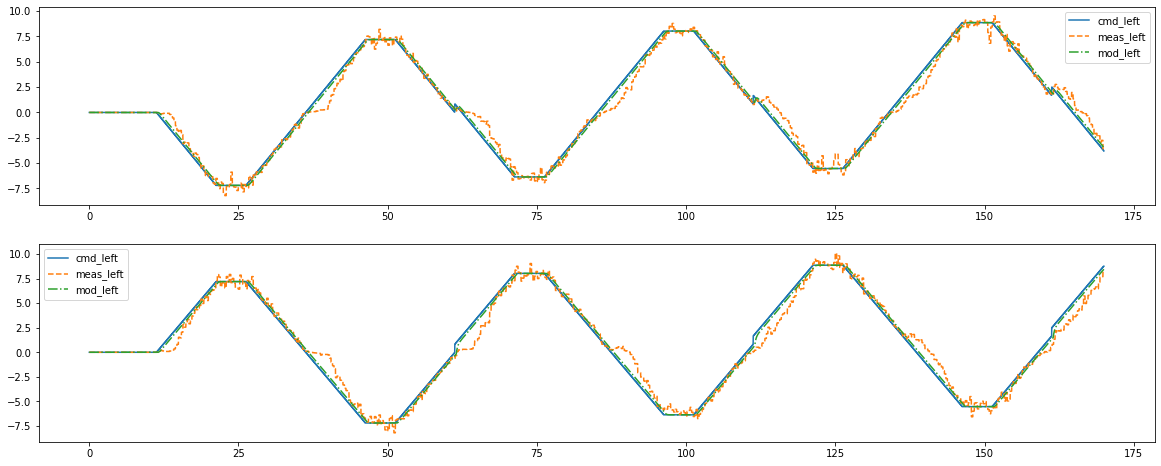

In [6]:
# plot commanded and measured wheel velocities

plt.figure(2, figsize=(20,8))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], left_model_vel[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='mod_left')
plt.legend()

plt.subplot(212)
plt.plot(time_arr[slice_start:slice_end], right_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], right_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], right_model_vel[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='mod_left')
plt.legend()

plt.show()

In [22]:
# Run EKF for model parameters (left-side)

tau_c = 0.1
tau_d = 0.1

left_EKF_mod_vel = np.zeros((meas_index_arr.shape[0]))
left_EKF_vel = np.zeros((meas_index_arr.shape[0]))
#right_model_vel = np.zeros((meas_index_arr.shape[0]))
pred_start = 0

d_tau_c = 0.01
tau_c_add = tau_c + d_tau_c
tau_c_sub = tau_c - d_tau_c

d_tau_d = 0.01
tau_d_add = tau_d + d_tau_d
tau_d_sub = tau_d - d_tau_d

vel_tau_c_add = 0
vel_tau_c_sub = 0

vel_tau_d_add = 0
vel_tau_d_sub = 0

left_vel_cmd_add = 0
left_vel_cmd_sub = 0
d_left_vel_cmd = 0.01
left_vel_cmd_add_arr = left_vel_cmd_arr + d_left_vel_cmd
left_vel_cmd_sub_arr = left_vel_cmd_arr - d_left_vel_cmd

P = np.array([[0.05, 0.0], [0.0, 0.05]])
trans_mat = np.array([[0.0,0.0], [0.0, 0.0]])
Cv = np.array([[0.005, 0.0], [0.0, 0.005]])

meas_jac = np.array([0.0, 0.0])
Cw = 10.0

tau_arr = np.zeros((left_vel_meas_arr.shape[0], 2))
tau_arr[0,0] = tau_c
tau_arr[0,1] = tau_d

I_2 = np.eye(2,2)


for i in range(1, time_arr.shape[0]-1): 
    dt = time_arr[i] - time_arr[i-1]
    
    left_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_vel, i, dt)
    
    vel_tau_c_add = vel_tau_c_add + powerTrain_vel(tau_c_add, tau_d, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
    vel_tau_c_sub = vel_tau_c_sub + powerTrain_vel(tau_c_sub, tau_d, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
    
    vel_tau_d_add = vel_tau_d_add + powerTrain_vel(tau_c, tau_d_add, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
    vel_tau_d_sub = vel_tau_d_sub + powerTrain_vel(tau_c, tau_d_sub, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
    
    left_vel_cmd_add = left_vel_cmd_add + powerTrain_vel(tau_c, tau_d, left_vel_cmd_add_arr, left_vel_meas_arr, i, dt)
    left_vel_cmd_sub = left_vel_cmd_sub + powerTrain_vel(tau_c, tau_d, left_vel_cmd_sub_arr, left_vel_meas_arr, i, dt)
    
    
    if left_vel_meas_arr[i+1] != left_vel_meas_arr[i]:
        meas_jac[0] = central_diff(vel_tau_c_add, vel_tau_c_sub, d_tau_c)
        meas_jac[1] = central_diff(vel_tau_d_add, vel_tau_d_sub, d_tau_d)
        comm_jac = central_diff(left_vel_cmd_add, left_vel_cmd_sub, d_left_vel_cmd)
        
        P = trans_mat @ P @ trans_mat.T + comm_jac ** 2 * Cv
        innov = left_vel_meas_arr[i+1] - left_EKF_vel[i+1]
        K_gain = P @ meas_jac.T * (meas_jac @ P @ meas_jac.T + Cw) ** (-1)
        tau_arr[i, :] = tau_arr[i-1,:] + K_gain * innov

        P = (I_2 - K_gain @ meas_jac) @ P

        tau_c = tau_arr[i,0]
        tau_d = tau_arr[i,1]
        
        vel_tau_c_add = 0
        vel_tau_c_sub = 0
        vel_tau_d_add = 0
        vel_tau_d_sub = 0
        left_vel_cmd_add = 0
        left_vel_cmd_sub = 0
        left_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
        
    else:
        tau_arr[i, :] = tau_arr[i-1,:]
    
    left_EKF_mod_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_mod_vel, i, dt)

In [23]:
print(tau_arr[17000])
tau_arr_left = tau_arr

[ 0.51850357 -0.00841372]


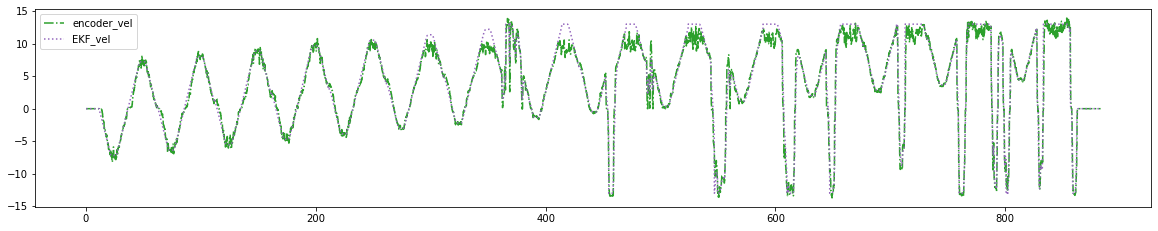

In [24]:
# plot commanded and measured wheel velocities
slice_start = 1
slice_end = time_arr.shape[0]
# max_vel = np.full(time_arr.shape[0], 10)

plt.figure(2, figsize=(20,8))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='encoder_vel')
plt.plot(time_arr[slice_start:slice_end], left_EKF_mod_vel[slice_start:slice_end], c='tab:purple', linestyle='dotted', label='EKF_vel')
# plt.plot(time_arr[slice_start:slice_end], max_vel[slice_start:slice_end], c='black', label='max_vel')
plt.legend()

plt.show()

In [25]:
# Run EKF for model parameters (right-side)

tau_c = 0.1
tau_d = 0.1

right_EKF_mod_vel = np.zeros((meas_index_arr.shape[0]))
right_EKF_vel = np.zeros((meas_index_arr.shape[0]))
#right_model_vel = np.zeros((meas_index_arr.shape[0]))
pred_start = 0

d_tau_c = 0.01
tau_c_add = tau_c + d_tau_c
tau_c_sub = tau_c - d_tau_c

d_tau_d = 0.01
tau_d_add = tau_d + d_tau_d
tau_d_sub = tau_d - d_tau_d

vel_tau_c_add = 0
vel_tau_c_sub = 0

vel_tau_d_add = 0
vel_tau_d_sub = 0

right_vel_cmd_add = 0
right_vel_cmd_sub = 0
d_right_vel_cmd = 0.01
right_vel_cmd_add_arr = right_vel_cmd_arr + d_right_vel_cmd
right_vel_cmd_sub_arr = right_vel_cmd_arr - d_right_vel_cmd

P = np.array([[0.05, 0.0], [0.0, 0.05]])
trans_mat = np.array([[0.0,0.0], [0.0, 0.0]])
Cv = np.array([[0.005, 0.0], [0.0, 0.005]])

meas_jac = np.array([0.0, 0.0])
Cw = 1.0

tau_arr = np.zeros((right_vel_meas_arr.shape[0], 2))
tau_arr[0,0] = tau_c
tau_arr[0,1] = tau_d

I_2 = np.eye(2,2)


for i in range(1, time_arr.shape[0]-1): 
    dt = time_arr[i] - time_arr[i-1]
    
    right_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, right_vel_cmd_arr, right_EKF_vel, i, dt)
    
    vel_tau_c_add = vel_tau_c_add + powerTrain_vel(tau_c_add, tau_d, right_vel_cmd_arr, right_vel_meas_arr, i, dt)
    vel_tau_c_sub = vel_tau_c_sub + powerTrain_vel(tau_c_sub, tau_d, right_vel_cmd_arr, right_vel_meas_arr, i, dt)
    
    vel_tau_d_add = vel_tau_d_add + powerTrain_vel(tau_c, tau_d_add, right_vel_cmd_arr, right_vel_meas_arr, i, dt)
    vel_tau_d_sub = vel_tau_d_sub + powerTrain_vel(tau_c, tau_d_sub, right_vel_cmd_arr, right_vel_meas_arr, i, dt)
    
    right_vel_cmd_add = right_vel_cmd_add + powerTrain_vel(tau_c, tau_d, right_vel_cmd_add_arr, right_vel_meas_arr, i, dt)
    right_vel_cmd_sub = right_vel_cmd_sub + powerTrain_vel(tau_c, tau_d, right_vel_cmd_sub_arr, right_vel_meas_arr, i, dt)
    
    
    if right_vel_meas_arr[i+1] != right_vel_meas_arr[i]:
        meas_jac[0] = central_diff(vel_tau_c_add, vel_tau_c_sub, d_tau_c)
        meas_jac[1] = central_diff(vel_tau_d_add, vel_tau_d_sub, d_tau_d)
        comm_jac = central_diff(right_vel_cmd_add, right_vel_cmd_sub, d_right_vel_cmd)
        
        P = trans_mat @ P @ trans_mat.T + comm_jac ** 2 * Cv
        innov = right_vel_meas_arr[i+1] - right_EKF_vel[i+1]
        K_gain = P @ meas_jac.T * (meas_jac @ P @ meas_jac.T + Cw) ** (-1)
        tau_arr[i, :] = tau_arr[i-1,:] + K_gain * innov

        P = (I_2 - K_gain @ meas_jac) @ P

        tau_c = tau_arr[i,0]
        tau_d = tau_arr[i,1]
        
        vel_tau_c_add = 0
        vel_tau_c_sub = 0
        vel_tau_d_add = 0
        vel_tau_d_sub = 0
        right_vel_cmd_add = 0
        right_vel_cmd_sub = 0
        right_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, right_vel_cmd_arr, right_EKF_vel, i, dt)
        
    else:
        tau_arr[i, :] = tau_arr[i-1,:]
    
    right_EKF_mod_vel[i+1] =  powerTrain_vel(tau_c, tau_d, right_vel_cmd_arr, right_EKF_mod_vel, i, dt)

In [26]:
print(tau_arr)
tau_arr_right = tau_arr

[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]
 ...
 [0.34392831 0.0973261 ]
 [0.34392831 0.0973261 ]
 [0.         0.        ]]


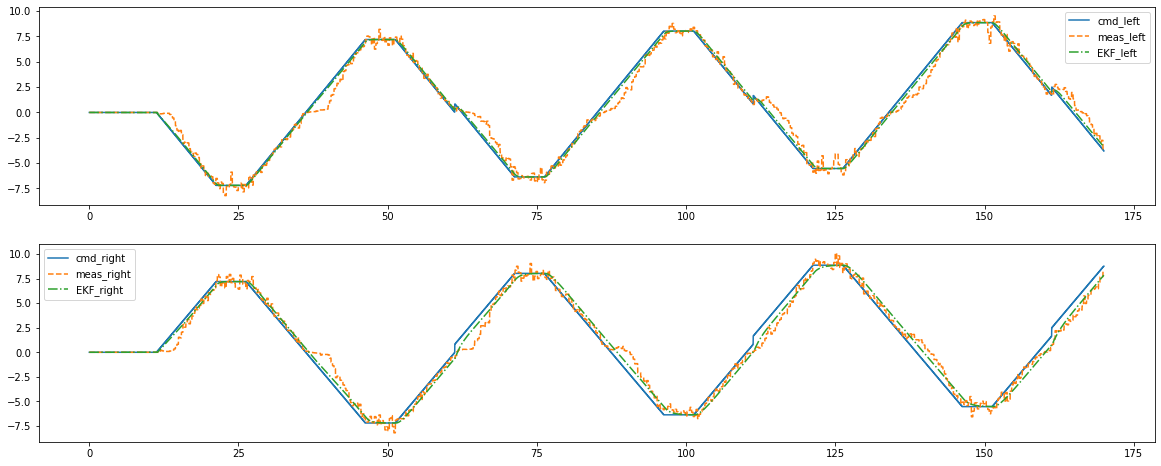

In [27]:
# plot commanded, measured wheel and EKF velocities
slice_start = 1
slice_end = 17000

plt.figure(2, figsize=(20,8))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], left_EKF_mod_vel[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='EKF_left')
plt.legend()
plt.subplot(212)
plt.plot(time_arr[slice_start:slice_end], right_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_right')
plt.plot(time_arr[slice_start:slice_end], right_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_right')
plt.plot(time_arr[slice_start:slice_end], right_EKF_mod_vel[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='EKF_right')
plt.legend()

plt.show()

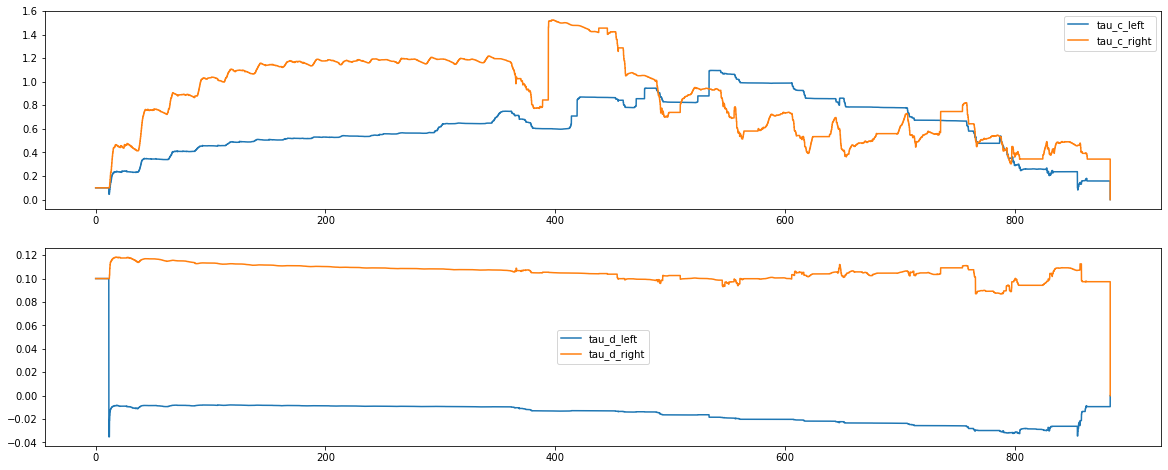

In [28]:
# Plot parameter evolution for both sides

plt.figure(2, figsize=(20,8))
plt.subplot(211)
plt.plot(time_arr, tau_arr_left[:,0], c='tab:blue', label='tau_c_left')
plt.plot(time_arr, tau_arr_right[:,0], c='tab:orange', label='tau_c_right')
plt.legend()

plt.figure(2, figsize=(20,8))
plt.subplot(212)
plt.plot(time_arr, tau_arr_left[:,1], c='tab:blue', label='tau_d_left')
plt.plot(time_arr, tau_arr_right[:,1], c='tab:orange', label='tau_d_right')
plt.legend()

In [17]:
# save data
np.savetxt("data/left_ekf_mod_vel.csv", left_EKF_mod_vel, delimiter=",")
np.savetxt("data/right_ekf_mod_vel.csv", right_EKF_mod_vel, delimiter=",")